# NCAR EDA: Daymet

## Intro
The purpose of this notebook is to perform exploratory data analysis (EDA) for the NCAR **Daymet** portion of the Alaska Near Surface Meteorology Daily Averages and the Alaska VIC Hydro Model Output [dataset](https://www.earthsystemgrid.org/dataset/ucar.ral.hydro.predictions.html). These data are available for download from the Climate Data Gateway at NCAR. The Daymet data are essentially the historical baseline for this dataset. The data are 12 km resolution for the period 1980–2017, and were aggregated from the 1-km Daymet dataset version 3 (Thornton et al. 2016). Per the article that describes this dataset:

The length of observed data...(37 years)...is shorter than the 50-year record used for CONUS hydroclimate projection work. With a shorter length observational dataset, the uncertainty in extreme events in the downscaled product may become greater because the short observation record length increases the uncertainty in the tails (extreme events) of the observed cumulative distribution used for quantile mapping based bias correction (Wood et al., 2004).

The goal of this EDA notebook is to execute some of the normal tasks (what is here? what is missing?) **and** to lay the groundwork for comparing the projections to the historical baseline in the spirit of QCing the projected data. For example, if the maximum value of a certain projected variable exceeds the baseline by 10000X....then we might wish to prescribe a data cap and truncate those extreme values.

The daymet data have the same basic structure as the projected data in terms of variables and variable groups, so see the `exploratory_data_analysis` notebook if you are not sure what is going on here.

## Data Fetch
The NCAR Climate Data Gateway provides a few mechanisms to download the necessary data. You can select the data you want and create an auto-generated shell download script:

`download_scripts/download_alaska_vic_daymet.sh`

To download the source data just execute these scripts from a working directory where you'd like to download the data to. I've download the full set of data to `/atlas_scratch/cparr4/ncar_replacement_data/daymet` - the "replacment" indicates that these data are distinct from the preliminary data we already had on disk. This is a basically a mirror of what NCAR is serving. The total download is 10GB.

In [1]:
import os
from pathlib import Path
from config import daymet_dir

## Count the Files

There are (4) file sets (the met data plus the three flavors of VIC output) and 1980-2017 (37) years worth of output. We should therefore have 4 * 37 total files.

In [2]:
total_files = 4 * 37
total_files

148

In [3]:
from config import variable_di

In [4]:
paths = list(daymet_dir.glob('*.nc'))
assert len(paths) == total_files

In [5]:
# energy balance (eb) is outside scope, but we'll include it in our file counting
all_var_groups = list(variable_di.keys())
all_var_groups.append("eb")
all_var_groups

['met', 'wf', 'ws', 'eb']

In [6]:
var_group_di = {}
for var_group in all_var_groups:
    var_group_di[var_group] = []

for nc_file in paths:
    
    file_var_group = nc_file.name.split("_")[1]
    var_group_di[file_var_group].append(nc_file)

In [7]:
assert set([len(var_group_di[x]) for x in var_group_di.keys()]) == set([37])

OK so we've established that the number of files downloaded is as expected, at that those file are evenly distributed amongst the variable groupings. That's good. Next we'll check the global attributes of these netCDF files. Based on what we know about the dataset so far, the files vary the most across the "variable groupings" axis - so we'll chunk this up that way.

In [8]:
import xarray as xr
from tqdm import tqdm
import numpy as np

normal_dim = [209, 299, 365]
leap_dim = [209, 299, 366]

with xr.open_dataset(daymet_dir / "daymet_met_1988.nc") as ds:
    met_ref_coords = ds.coords
    
unruly_files = []

for var_group in var_group_di.keys():
    # omit the energy balance variables - out of scope
    if var_group != "eb":
        ds_dims = []
        ds_indices = []
        ds_coords = []
        for nc_file in tqdm(var_group_di[var_group], desc=f"Scanning {var_group} variable group"):
            with xr.open_dataset(nc_file) as ds:

                # check data three dimensional (time)
                dims = list(ds.dims.values())
                if sorted(dims) == normal_dim or sorted(dims) == leap_dim:
                    pass
                else:
                    print(f"{nc_file.name} has unusual dimensions of {dims}")
                    unruly_files.append(nc_file)

                # check daily frequency including leap years
                if ds.coords["time"].shape[0] == 365 or ds.coords["time"].shape[0] == 366:
                    pass
                else:
                    print(f"{nc_file.name} has unusual coordinates of {ds.coords}")
                    unruly_files.append(nc_file)

                ds_indices.append(ds.indexes)

                # check expected variables exist in each file as a DataArray
                data_vars = set(list(ds.data_vars.keys()))
                ref_vars = set(list(variable_di[var_group].keys()))
                test_vars = set.intersection(data_vars, ref_vars)
                if test_vars == ref_vars:
                    pass
                else:
                    print(f"{nc_file.name} only has the following data variables: {data_vars}")
                    
        if len(np.unique(ds_indices)) == 1:
            print("All files have the same indices.")
        else:
            print("Some files have different indices.")
            print(np.unique(ds_indices))

Scanning met variable group: 100%|████████████████████████████████| 37/37 [00:02<00:00, 16.27it/s]


All files have the same indices.


Scanning wf variable group: 100%|█████████████████████████████████| 37/37 [00:02<00:00, 16.80it/s]


All files have the same indices.


Scanning ws variable group: 100%|█████████████████████████████████| 37/37 [00:03<00:00, 10.62it/s]

All files have the same indices.


In [9]:
np.unique(unruly_files)

array([], dtype=float64)

Excellent, the daymet data appear homogeneous: files have the expected variables and are structured with the same 209 X 299 spatial grid and with a daily time-step, including leap years. The next step is to start sampling for value ranges and nodata values.

In [10]:
import dask
import dask.array as da
from dask.distributed import Client
from dask import delayed
from tqdm.notebook import tqdm_notebook

# define a delayed function to compute stats for all variables for a single file
@delayed
def compute_stats_for_file(file, ref_vars):
    with xr.open_dataset(file) as ds:
        file_stats = {}
        for variable in ref_vars:
            da = ds[variable].chunk()  # chunk the data for parallel processing
            file_stats[variable] = {"filename": file.name,
                                    "min_vals": float(da.min()),
                                    "mean_vals": float(da.mean()),
                                    "max_vals": float(da.max()),
                                    "nan_count": float(da.isnull().sum()),
                                    "arr_size": float(da.size)}
        return file_stats

# create dask client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 251.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46125,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 251.72 GiB
Comm: tcp://127.0.0.1:45373,Total threads: 4
Dashboard: http://127.0.0.1:34858/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:38593,


In [11]:
import pandas as pd

summary_stat_di = {}

for var_group in var_group_di.keys():
    # omit the energy balance variables - out of scope
    if var_group != "eb":
        ref_vars = list(variable_di[var_group].keys())
        
        all_file_stats = []

        for nc_file in tqdm_notebook(var_group_di[var_group], desc=f"Sampling values from the {var_group} variable group"):
            all_file_stats.append(compute_stats_for_file(nc_file, ref_vars))
        stat_result = dask.compute(*all_file_stats)
        init_df = pd.DataFrame.from_dict(stat_result).T
        
        # each column of the df contains a dict of summary statistics from one file
        # each row of the df corresponds to a variable
        # transform this such that each dict key is a column, and each row is a file
        
        output_dfs = []

        for idx in init_df.index:
            row_dict = init_df.loc[idx].to_dict()
            df = pd.DataFrame(row_dict).T
            df["variable"] = idx
            output_dfs.append(df)
        summary_stat_di[var_group] = pd.concat(output_dfs)
        

met


Sampling values from the met variable group:   0%|          | 0/37 [00:00<?, ?it/s]

wf


Sampling values from the wf variable group:   0%|          | 0/37 [00:00<?, ?it/s]

ws


Sampling values from the ws variable group:   0%|          | 0/37 [00:00<?, ?it/s]

eb


In [12]:
summary_stat_di

{'met':               filename min_vals mean_vals    max_vals   nan_count    arr_size  \
 0   daymet_met_1991.nc      0.0  2.138255  173.073898  17607965.0  22809215.0   
 1   daymet_met_1980.nc      0.0  1.968405       200.0  17656206.0  22871706.0   
 2   daymet_met_1981.nc      0.0  2.085144  170.704437  17607965.0  22809215.0   
 3   daymet_met_1982.nc      0.0  1.936665       200.0  17607965.0  22809215.0   
 4   daymet_met_1983.nc      0.0  1.724509       200.0  17607965.0  22809215.0   
 ..                 ...      ...       ...         ...         ...         ...   
 32  daymet_met_2012.nc    -51.0 -9.181389   17.851229  17656206.0  22871706.0   
 33  daymet_met_2013.nc    -51.0 -7.609197   21.711866  17607965.0  22809215.0   
 34  daymet_met_2014.nc    -51.0 -6.186203    20.78591  17607965.0  22809215.0   
 35  daymet_met_2015.nc    -51.0 -6.100663        18.5  17607965.0  22809215.0   
 36  daymet_met_2016.nc    -51.0 -5.251588        19.0  17656206.0  22871706.0   
 
    var

In [13]:
# we'll dump the results of this analysis to a pickle file
# this way we can jump back in to the analysis without having to re-run the time consuming extraction of the values
import pickle
with open("daymet_eda_summary_stats.pickle", "wb") as handle:
    pickle.dump(summary_stat_di, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
client.close()

In [15]:
import pickle
with open("daymet_eda_summary_stats.pickle", "rb") as handle:
    summary_stat_di = pickle.load(handle)

Let's check the results for the `met` variables of:


 - tmax (Maximum Daily 2-m air temperature, °C)
 - tmin (Minimum Daily 2-m air temperature, °C)
 - pcp (Daily precipitation, mm per day)

We'd expect `pcp` to have a minimum bound at zero - there should not be any negative precipitation amounts.
We'd expect temperatures to range between around -70°F and 110°F, or about -57°C and 44°C. 

Recall that for each variable and for each file (one file per year, daily frequency data) we extracted min, mean, and max values. We'll summarize each of those values again by min, mean, and max to see some values for each variable.

In [16]:
summary_stat_di["met"].drop(["filename"], axis=1).groupby("variable").min().round(1) # the min values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
pcp,0.0,1.6,136.2,17607965.0,22809215.0
tmax,-50.0,-0.4,28.9,17607965.0,22809215.0
tmin,-51.0,-9.7,14.5,17607965.0,22809215.0


The **minimums** of the min-mean-max-value extractions looks OK. The `pcp` min is zero as expected and the coldest `tmax` and `tmin` temps in this entire dataset are about -50°C, which makes sense to me. Good to see a stable minimum `nan_count` - put another way, the maximum data extent for each of these variables is indentical.

In [17]:
summary_stat_di["met"].drop(["filename"], axis=1).groupby("variable").mean().round(1) # the mean values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
pcp,0.0,2.1,190.4,17621003.1,22826104.5
tmax,-50.0,1.2,33.0,17621003.1,22826104.5
tmin,-51.0,-8.1,18.1,17621003.1,22826104.5


The means of the min-mean-max-value extractions also looks OK as well. The deltas between `tmin` and `tmax` seem right: `tmax` is warmer for all cases. Consider the average maximum `pcp` value of 190 mm, or 19 cm. That's about 7.5 inches of rain which seems like a reasonable "aveage maximum" 24-hr precip total.

In [18]:
summary_stat_di["met"].drop(["filename"], axis=1).groupby("variable").max().round(1) # the max values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
pcp,0.0,2.4,200.0,17656206.0,22871706.0
tmax,-50.0,3.6,40.6,17656206.0,22871706.0
tmin,-51.0,-5.3,23.0,17656206.0,22871706.0


These max values look OK - maybe I would have expected more `pcp`

In [19]:
import numpy as np
np.unique(summary_stat_di["met"]["nan_count"], return_counts=True)

(array([17607965.0, 17656206.0], dtype=object), array([81, 30]))

In [20]:
np.unique(summary_stat_di["met"]["arr_size"], return_counts=True)

(array([22809215.0, 22871706.0], dtype=object), array([81, 30]))

In [21]:
summary_stat_di["met"][summary_stat_di["met"]["nan_count"] == 17656206.0]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
1,daymet_met_1980.nc,0.0,1.968405,200.0,17656206.0,22871706.0,pcp
5,daymet_met_1984.nc,0.0,1.660309,136.227524,17656206.0,22871706.0,pcp
9,daymet_met_1988.nc,0.0,2.043928,200.0,17656206.0,22871706.0,pcp
12,daymet_met_1992.nc,0.0,2.018651,200.0,17656206.0,22871706.0,pcp
16,daymet_met_1996.nc,0.0,1.628603,200.0,17656206.0,22871706.0,pcp
20,daymet_met_2000.nc,0.0,2.122856,164.28241,17656206.0,22871706.0,pcp
24,daymet_met_2004.nc,0.0,2.149599,174.079391,17656206.0,22871706.0,pcp
28,daymet_met_2008.nc,0.0,2.28623,172.745575,17656206.0,22871706.0,pcp
32,daymet_met_2012.nc,0.0,2.267956,200.0,17656206.0,22871706.0,pcp
36,daymet_met_2016.nc,0.0,2.197299,173.376617,17656206.0,22871706.0,pcp


In [22]:
summary_stat_di["met"][summary_stat_di["met"]["arr_size"] == 22871706]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
1,daymet_met_1980.nc,0.0,1.968405,200.0,17656206.0,22871706.0,pcp
5,daymet_met_1984.nc,0.0,1.660309,136.227524,17656206.0,22871706.0,pcp
9,daymet_met_1988.nc,0.0,2.043928,200.0,17656206.0,22871706.0,pcp
12,daymet_met_1992.nc,0.0,2.018651,200.0,17656206.0,22871706.0,pcp
16,daymet_met_1996.nc,0.0,1.628603,200.0,17656206.0,22871706.0,pcp
20,daymet_met_2000.nc,0.0,2.122856,164.28241,17656206.0,22871706.0,pcp
24,daymet_met_2004.nc,0.0,2.149599,174.079391,17656206.0,22871706.0,pcp
28,daymet_met_2008.nc,0.0,2.28623,172.745575,17656206.0,22871706.0,pcp
32,daymet_met_2012.nc,0.0,2.267956,200.0,17656206.0,22871706.0,pcp
36,daymet_met_2016.nc,0.0,2.197299,173.376617,17656206.0,22871706.0,pcp


Ok so the 30 files that have different "nodata" values and smaller array sizes than the rest of the dataset are just **leap years!** Cool.

Next we'll check the results for the `wf` variables of:


 - RUNOFF (surface runoff, mm per day)
 - EVAP (actual evapotranspiration, mm per day)
 - SNOW_MELT (snow melt, mm per day)
 - GLACER_MELT (ice melt, mm per day)


We'd expect all of these variables to have minimum bounds at zero - there should not be any negative water amounts...that wouldn't really make sense. Only exceptions might be if these variables mean something else in a modeling context. `RUNOFF` and `SNOW_MELT` value ranges should be similar to precip value ranges we looked at earlier, and we can infer from this [WRCC source](https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg) that summertime `EVAP` rates might be in the 0 to 10 mm per day range. Recall that for each variable and for each file (one file per year, daily frequency data) we extracted min, mean, and max values. We'll summarize each of those values again by min, mean, and max to see some values for each variable.

In [23]:
summary_stat_di["wf"].drop(["filename"], axis=1).groupby("variable").min().round(1) # the min values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
EVAP,-10.6,0.6,5.6,17616360.0,22809215.0
GLACIER_MELT,0.0,8.2,2452.0,17616360.0,22809215.0
RUNOFF,0.0,1.1,706.4,17616360.0,22809215.0
SNOW_MELT,-0.0,1.3,777.2,17616360.0,22809215.0


Well the smallest value in the entire dataset for `EVAP` and `SNOW_MELT` are slightly negative - shrug.

In [24]:
summary_stat_di["wf"].drop(["filename"], axis=1).groupby("variable").mean().round(1) # the mean values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
EVAP,-7.1,0.6,6.5,17629404.3,22826104.5
GLACIER_MELT,0.0,20.2,3015.7,17629404.3,22826104.5
RUNOFF,0.0,1.5,931.3,17629404.3,22826104.5
SNOW_MELT,-0.0,1.8,1024.2,17629404.3,22826104.5


The average of minimum `EVAP` values is -7.1, which seems signficant given the average of the mean `EVAP` values is only 0.6. This makes me think that the negative `EVAP` values mean something - and aren't just float noise.

In [25]:
summary_stat_di["wf"].drop(["filename"], axis=1).groupby("variable").max().round(1) # the max values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
EVAP,-4.6,0.7,7.7,17664624.0,22871706.0
GLACIER_MELT,0.0,41.2,4081.2,17664624.0,22871706.0
RUNOFF,0.0,1.9,1121.7,17664624.0,22871706.0
SNOW_MELT,0.0,2.4,1313.9,17664624.0,22871706.0


These values look fine. That max `GLACIAL_MELT` value is  about 160 inches of water in **one day**.

In [26]:
np.unique(summary_stat_di["wf"]["nan_count"], return_counts=True)

(array([17616360.0, 17664624.0], dtype=object), array([108,  40]))

In [27]:
np.unique(summary_stat_di["wf"]["arr_size"], return_counts=True)

(array([22809215.0, 22871706.0], dtype=object), array([108,  40]))

In [28]:
summary_stat_di["wf"][summary_stat_di["wf"]["arr_size"] == 22871706]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
0,daymet_wf_1980.nc,0.0,2.202512,1005.171997,17664624.0,22871706.0,SNOW_MELT
4,daymet_wf_1984.nc,0.0,2.05196,930.833008,17664624.0,22871706.0,SNOW_MELT
8,daymet_wf_1988.nc,0.0,1.891386,1019.546997,17664624.0,22871706.0,SNOW_MELT
12,daymet_wf_1992.nc,0.0,1.788358,1313.906982,17664624.0,22871706.0,SNOW_MELT
16,daymet_wf_1996.nc,-0.001,1.525113,1001.903992,17664624.0,22871706.0,SNOW_MELT
20,daymet_wf_2000.nc,-0.002,1.578477,996.286987,17664624.0,22871706.0,SNOW_MELT
24,daymet_wf_2004.nc,-0.002,1.779908,1024.546021,17664624.0,22871706.0,SNOW_MELT
28,daymet_wf_2008.nc,-0.002,1.473028,1042.890015,17664624.0,22871706.0,SNOW_MELT
32,daymet_wf_2012.nc,-0.002,1.452479,1018.015015,17664624.0,22871706.0,SNOW_MELT
36,daymet_wf_2016.nc,-0.002,1.405477,994.137024,17664624.0,22871706.0,SNOW_MELT


Same leap year stuff here, nothig to worry about.

Finally let's check the results for the `ws` variables of:

 - SWE (Snow water equivalent, mm)
 - IWE (Ice water equivalent, mm)
 - SM1 (Soil moisture layer1, mm)
 - SM2 (Soil moisture layer1, mm)
 - SM3 (Soil moisture layer3, mm)
 
My understanding is that these variables all indicate **water state**, or the amount of water present in a grid cell at a given time step. My expectation is that we will not see any negative values here, because a negative amount of water wouldn't make sense. 

In [29]:
summary_stat_di["ws"].drop(["filename"], axis=1).groupby("variable").min().round(1) # the min values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
IWE,0.0,4817.1,213022.8,17616360.0,22809215.0
SM1,0.0,7.7,13.0,17616360.0,22809215.0
SM2,74.2,325.3,609.8,17616360.0,22809215.0
SM3,0.0,12.6,163.3,17616360.0,22809215.0
SWE,0.0,63.9,36467.9,17616360.0,22809215.0


In [30]:
summary_stat_di["ws"].drop(["filename"], axis=1).groupby("variable").mean().round(1) # the mean values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
IWE,0.0,8193.3,255457.6,17629404.3,22826104.5
SM1,0.0,8.1,13.0,17629404.3,22826104.5
SM2,81.4,344.3,624.7,17629404.3,22826104.5
SM3,0.0,15.9,166.9,17629404.3,22826104.5
SWE,0.0,91.9,46512.5,17629404.3,22826104.5


In [31]:
summary_stat_di["ws"].drop(["filename"], axis=1).groupby("variable").max().round(1) # the max values

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
IWE,0.0,13753.6,340264.9,17664624.0,22871706.0
SM1,0.0,8.7,13.0,17664624.0,22871706.0
SM2,94.7,361.3,630.1,17664624.0,22871706.0
SM3,0.0,19.2,170.8,17664624.0,22871706.0
SWE,0.0,112.2,63117.0,17664624.0,22871706.0


`SM2` never goes dry? Is that because there is always some water storage there? But then why is `SM3` dry in some cases - maybe there are soil or rock coverages where water never penetrates that deep. That'd make sense for less penetrable cases like exposed bedrock or something.

In [32]:
np.unique(summary_stat_di["ws"]["nan_count"], return_counts=True)

(array([17616360.0, 17664624.0], dtype=object), array([135,  50]))

In [33]:
np.unique(summary_stat_di["ws"]["arr_size"], return_counts=True)

(array([22809215.0, 22871706.0], dtype=object), array([135,  50]))

In [34]:
# check for leap years again
summary_stat_di["wf"][summary_stat_di["wf"]["arr_size"] == 22871706]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
0,daymet_wf_1980.nc,0.0,2.202512,1005.171997,17664624.0,22871706.0,SNOW_MELT
4,daymet_wf_1984.nc,0.0,2.05196,930.833008,17664624.0,22871706.0,SNOW_MELT
8,daymet_wf_1988.nc,0.0,1.891386,1019.546997,17664624.0,22871706.0,SNOW_MELT
12,daymet_wf_1992.nc,0.0,1.788358,1313.906982,17664624.0,22871706.0,SNOW_MELT
16,daymet_wf_1996.nc,-0.001,1.525113,1001.903992,17664624.0,22871706.0,SNOW_MELT
20,daymet_wf_2000.nc,-0.002,1.578477,996.286987,17664624.0,22871706.0,SNOW_MELT
24,daymet_wf_2004.nc,-0.002,1.779908,1024.546021,17664624.0,22871706.0,SNOW_MELT
28,daymet_wf_2008.nc,-0.002,1.473028,1042.890015,17664624.0,22871706.0,SNOW_MELT
32,daymet_wf_2012.nc,-0.002,1.452479,1018.015015,17664624.0,22871706.0,SNOW_MELT
36,daymet_wf_2016.nc,-0.002,1.405477,994.137024,17664624.0,22871706.0,SNOW_MELT


Next we'll plot some of the extreme value time slices for each variable

In [35]:
met_pcp_df = summary_stat_di["met"].set_index("filename").query("variable == 'pcp'")
met_tmin_df = summary_stat_di["met"].set_index("filename").query("variable == 'tmin'")
met_tmax_df = summary_stat_di["met"].set_index("filename").query("variable == 'tmax'")

In [36]:
import matplotlib.pyplot as plt
max_pcp = met_pcp_df.sort_values("max_vals").index[-1]
min_tmin = met_tmin_df.sort_values("max_vals").index[0]
max_tmax = met_tmax_df.sort_values("max_vals").index[-1]

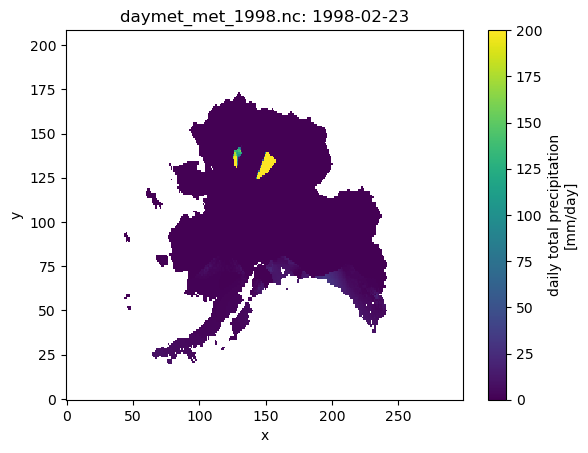

In [37]:
with xr.open_dataset(daymet_dir / max_pcp) as ds:
    
    da = ds.pcp
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_pcp}: {tstr}")

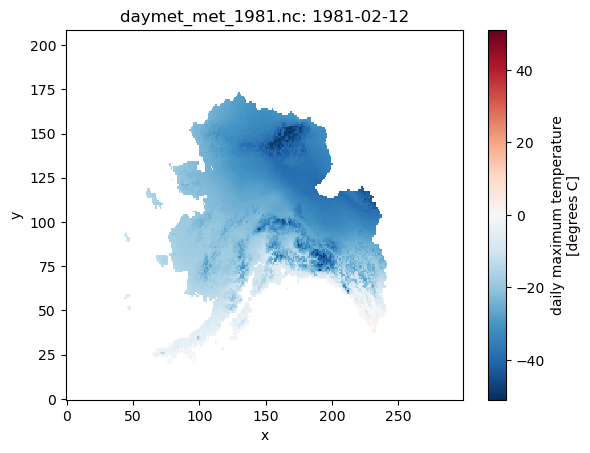

In [38]:
with xr.open_dataset(daymet_dir / min_tmin) as ds:
    
    da = ds.tmin
    min_val = da.min()
    min_loc = da.argmin()

    min_loc_tuple = np.unravel_index(min_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[min_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{min_tmin}: {tstr}")

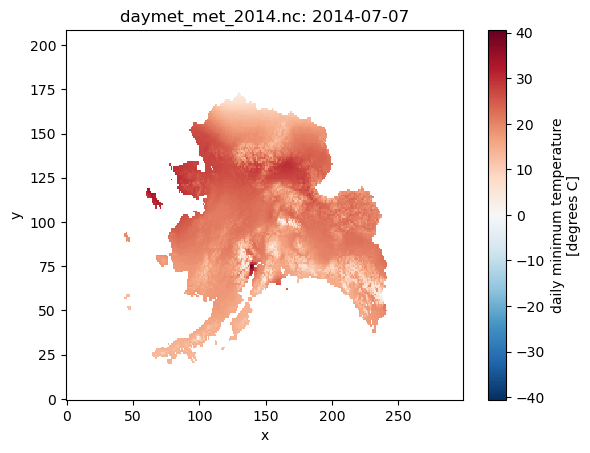

In [39]:
with xr.open_dataset(daymet_dir / max_tmax) as ds:
    
    da = ds.tmax
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]
    da.sel(time=time_slice).plot()
    plt.title(f"{max_tmax}: {tstr}")

In [40]:
ws_swe_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SWE'")
ws_iwe_df = summary_stat_di["ws"].set_index("filename").query("variable == 'IWE'")
ws_sm1_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SM1'")
ws_sm2_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SM2'")
ws_sm3_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SM3'")

In [41]:
max_swe = ws_swe_df.sort_values("max_vals").index[-1]
max_iwe = ws_iwe_df.sort_values("max_vals").index[-1]
max_sm1 = ws_sm1_df.sort_values("max_vals").index[-1]
max_sm2 = ws_sm2_df.sort_values("max_vals").index[-1]
max_sm3 = ws_sm3_df.sort_values("max_vals").index[-1]

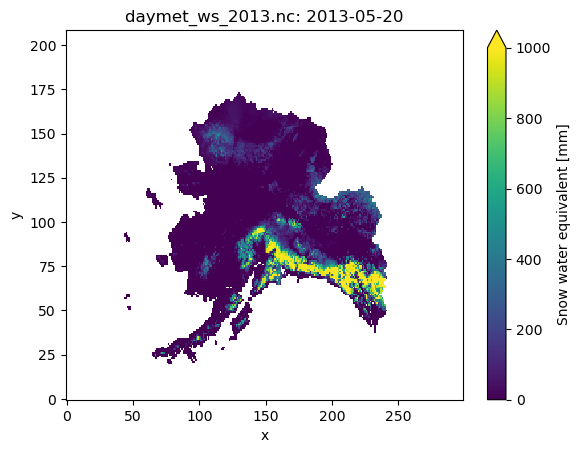

In [42]:
with xr.open_dataset(daymet_dir / max_swe) as ds:
    
    da = ds.SWE
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=1000)
    plt.title(f"{max_swe}: {tstr}")

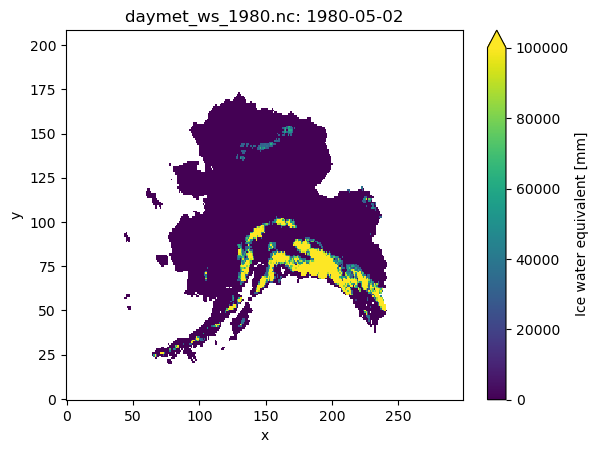

In [43]:
with xr.open_dataset(daymet_dir / max_iwe) as ds:
    
    da = ds.IWE
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=100000)
    plt.title(f"{max_iwe}: {tstr}")

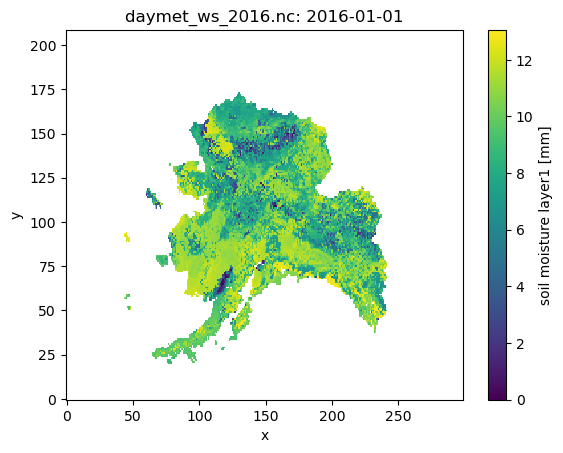

In [44]:
with xr.open_dataset(daymet_dir / max_sm1) as ds:
    
    da = ds.SM1
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_sm1}: {tstr}")

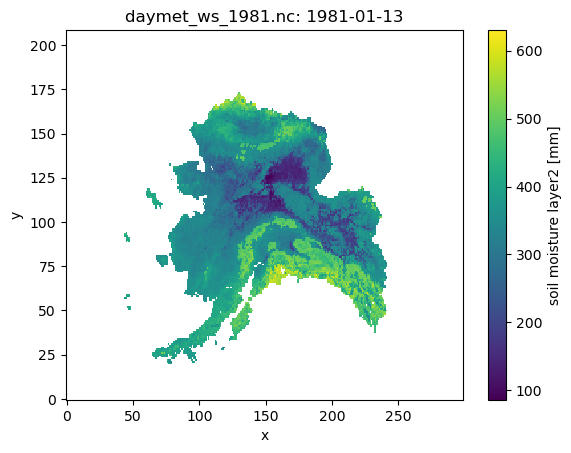

In [45]:
with xr.open_dataset(daymet_dir / max_sm2) as ds:
    
    da = ds.SM2
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_sm2}: {tstr}")

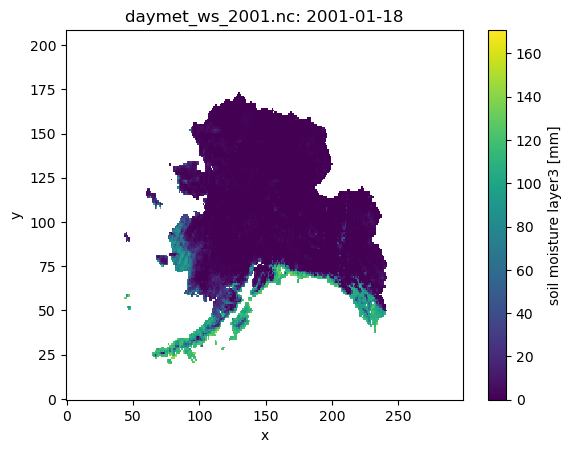

In [46]:
with xr.open_dataset(daymet_dir / max_sm3) as ds:
    
    da = ds.SM3
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_sm3}: {tstr}")

In [47]:
wf_evap_df = summary_stat_di["wf"].set_index("filename").query("variable == 'EVAP'")
wf_glacmelt_df = summary_stat_di["wf"].set_index("filename").query("variable == 'GLACIER_MELT'")
wf_runoff_df = summary_stat_di["wf"].set_index("filename").query("variable == 'RUNOFF'")
wf_snowmelt_df = summary_stat_di["wf"].set_index("filename").query("variable == 'SNOW_MELT'")

In [48]:
max_evap = wf_evap_df.sort_values("max_vals").index[-1]
max_glacmelt = wf_glacmelt_df.sort_values("max_vals").index[-1]
max_runoff = wf_runoff_df.sort_values("max_vals").index[-1]
max_snowmelt = wf_snowmelt_df.sort_values("max_vals").index[-1]

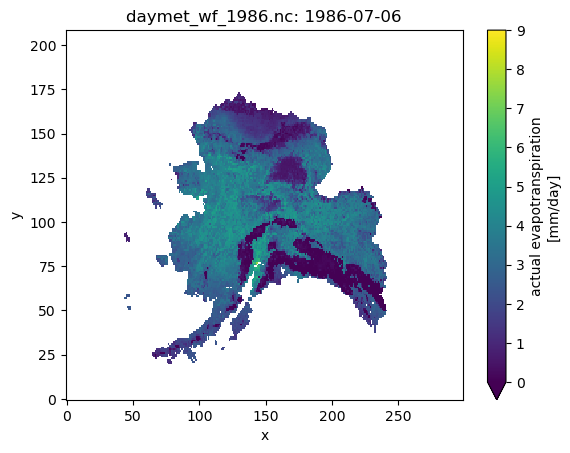

In [49]:
with xr.open_dataset(daymet_dir / max_evap) as ds:
    
    da = ds.EVAP
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmin=0, vmax=9)
    plt.title(f"{max_evap}: {tstr}")

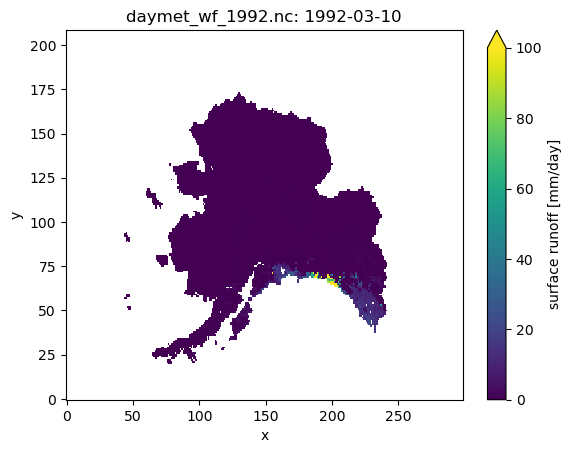

In [50]:
with xr.open_dataset(daymet_dir / max_runoff) as ds:
    
    da = ds.RUNOFF
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=100)
    plt.title(f"{max_runoff}: {tstr}")

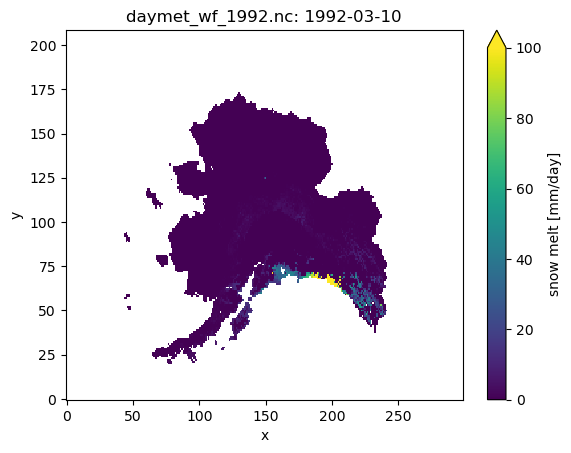

In [51]:
with xr.open_dataset(daymet_dir / max_snowmelt) as ds:
    
    da = ds.SNOW_MELT
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmin=0, vmax=100)
    plt.title(f"{max_snowmelt}: {tstr}")

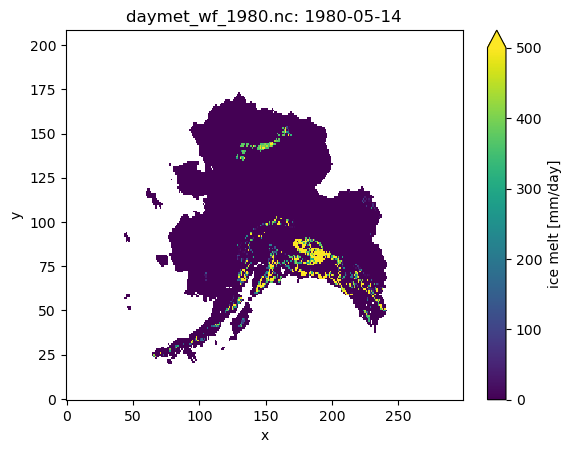

In [52]:
with xr.open_dataset(daymet_dir / max_glacmelt) as ds:
    
    da = ds.GLACIER_MELT
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=500)
    plt.title(f"{max_glacmelt}: {tstr}")

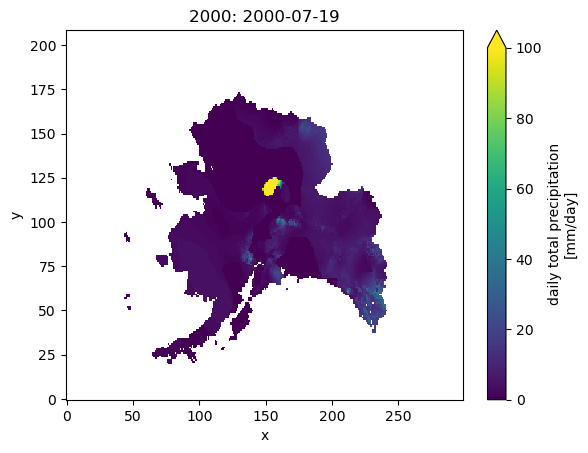

In [54]:
with xr.open_dataset(daymet_dir / "daymet_met_2000.nc") as ds:
    
    da = ds.pcp
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=100)
    plt.title(f"2000: {tstr}")

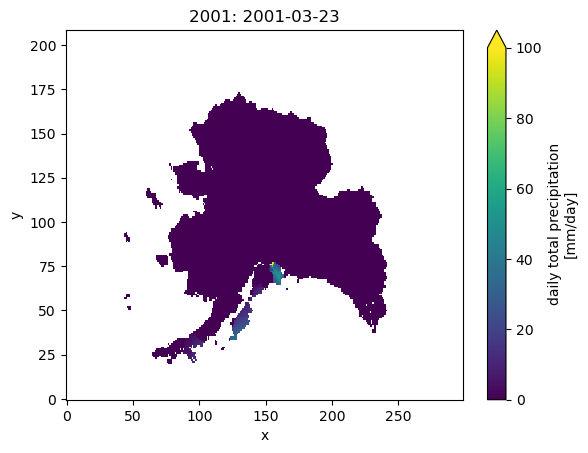

In [55]:
with xr.open_dataset(daymet_dir / "daymet_met_2001.nc") as ds:
    
    da = ds.pcp
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=100)
    plt.title(f"2001: {tstr}")

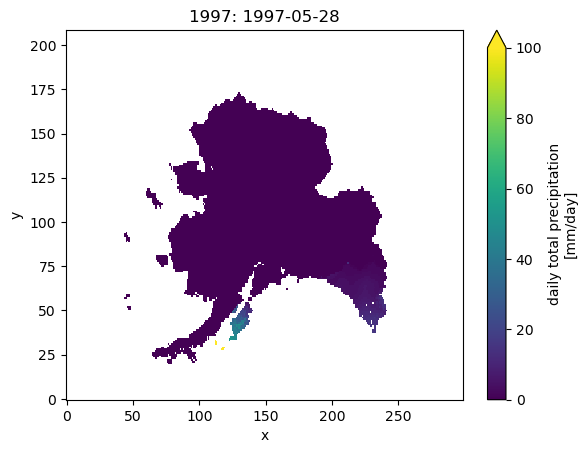

In [56]:
with xr.open_dataset(daymet_dir / "daymet_met_1997.nc") as ds:
    
    da = ds.pcp
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=100)
    plt.title(f"1997: {tstr}")

These patches in these precip slices are all much less angular than the maximum of the entire time series, and the timing (spring in southern AK, or July for the convective precip in Northern AK) makes more sense.